In [1]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.1
1.4.1


In [2]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes

In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_hourly', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'm4_weekly_id', 'my_weekly_tm', 'm4_yearly', 'm4_yearly_demographic', 'm4_yearly_domain', 

In [5]:
dataname = "m4_weekly_id"
dataset = get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_id.


In [6]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])


In [7]:
train_entry

{'start': Timestamp('1750-01-04 00:00:00', freq='W-SUN'),
 'item_id': 'W1',
 'target': array([ 1089.2 ,  1078.91,  1079.88, ..., 36565.18, 36565.18, 35397.16],
       dtype=float32),
 'feat_static_cat': array([1]),
 'source': SourceContext(source=Span(path=WindowsPath('C:/Users/TM/.mxnet/gluon-ts/datasets/m4_weekly_id/train/m4_weekly_id_train.json'), line=1), row=1)}

In [8]:
dataset.metadata.feat_static_cat

[<CategoricalFeatureInfo name='feat_static_cat' cardinality='359'>]

In [9]:
[feat_static_cat.cardinality for feat_static_cat in dataset.metadata.feat_static_cat]

['359']

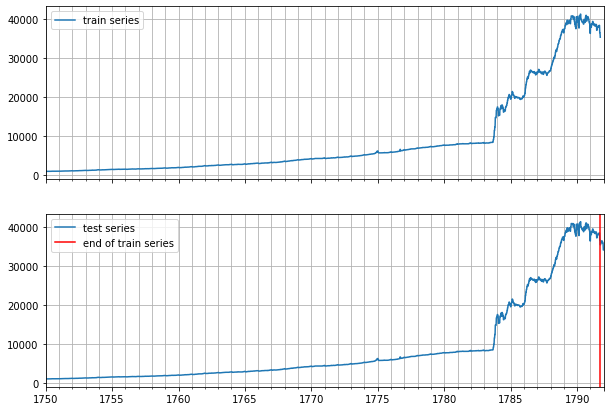

In [10]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [11]:
# gluonts
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# DeepAREstimator
from gluonts.model.deepar import DeepAREstimator

INFO:root:Using CPU


In [12]:
epochs=1
num_batches = 50


trainer = Trainer(
    ctx=mx.cpu(0),
    epochs=epochs,
    num_batches_per_epoch=num_batches,
    learning_rate=1e-3,
)

estimator = DeepAREstimator(
    trainer=trainer,
    cardinality= [
        feat_static_cat.cardinality 
        for feat_static_cat in dataset.metadata.feat_static_cat
    ],
    context_length=dataset.metadata.prediction_length,
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True
)

predictor = estimator.train(training_data=dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
    dataset.test, predictor=predictor, num_samples=100
    )

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.55it/s, avg_epoch_loss=8.05]
INFO:root:Epoch[0] Elapsed time 4.756 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.052087
INFO:root:Loading parameters from best epoch (0)
INFO:root:Final loss: 8.05208706855774 (occurred at epoch 0)
INFO:root:End model training


In [13]:
agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

Running evaluation: 100%|██████████| 359/359 [00:33<00:00, 10.60it/s]


In [14]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,sMAPE,MSIS,QuantileLoss[0.1],...,QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.6],Coverage[0.6],QuantileLoss[0.7],Coverage[0.7],QuantileLoss[0.8],Coverage[0.8],QuantileLoss[0.9],Coverage[0.9]
0,W1,3.179566e+06,20435.343750,464329.437500,35717.649038,63.683045,24.683957,0.043248,108.212663,5228.535156,...,20435.343750,1.000000,21615.296875,1.000000,21307.270313,1.000000,17992.496875,1.000000,12688.875000,1.000000
1,W2,3.650775e+04,2117.830811,46501.820312,3577.063101,12.059746,13.508582,0.044788,54.219970,361.979687,...,2117.830811,1.000000,2214.117773,1.000000,2131.763379,1.000000,1851.436621,1.000000,1266.904102,1.000000
2,W3,1.122427e+05,3382.568359,128300.796875,9869.292067,33.355166,7.800818,0.026616,47.702299,2754.792383,...,3382.568359,0.000000,2613.328906,0.230769,1612.028711,0.307692,1083.632031,0.923077,1382.114453,1.000000
3,W4,1.008478e+06,10602.628906,38126.421875,2932.801683,353.363468,2.308068,0.302992,72.228678,2625.131909,...,10602.628662,0.000000,12266.115820,0.000000,13661.280322,0.000000,14568.176660,0.076923,14731.437744,0.153846
4,W5,3.096599e+05,5958.990723,23475.000000,1805.769231,705.777154,0.649474,0.275673,20.243920,1502.707178,...,5958.990967,0.076923,6917.786475,0.076923,7711.424072,0.076923,8168.935693,0.153846,8265.374561,0.230769


In [20]:
item_metrics.to_csv("error_test_file.csv")